# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2021

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [ ]:
#@title Código básico de graficación (no modificar)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Ejemplo: agente CartPole

In [ ]:
import gym
import time
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    for _ in range(500):
        env.render(mode='human')
        observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [ ]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    observation = env.reset()
    for t in range(500):
        env.render(mode='human')
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [ ]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria

    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [ ]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - completa con tu código aquí
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [ ]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            learn(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
#tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

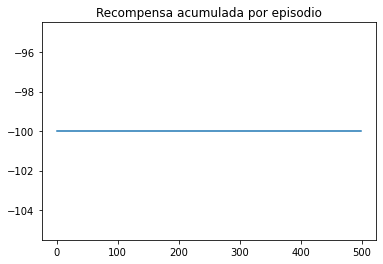

In [ ]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

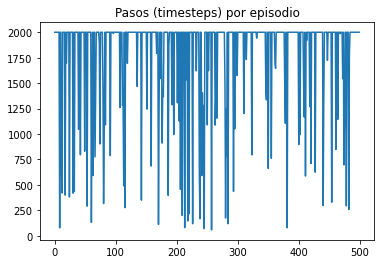

In [ ]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

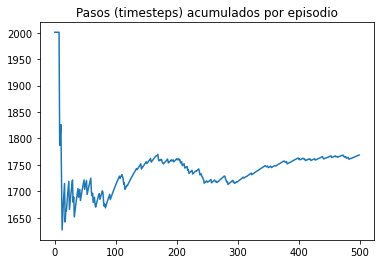

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

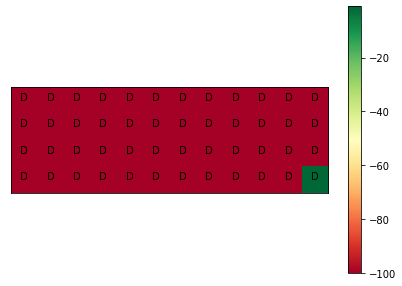


 Matriz de mejor acción-valor (en números): 

 [[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [ ]:
draw_value_matrix(q)

In [ ]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN

## Resolución de las actividades


#### 1. Implementación de SARSA en "The Cliff".

A continuación mostramos los resultados de implementar SARSA en el problema.

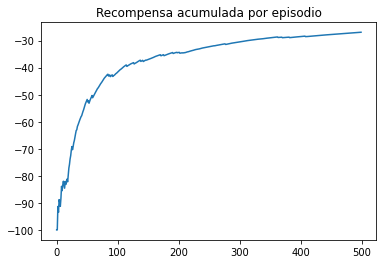

De este gráfico podemos observar que ya en el primer episodio cae al acantilado (que es el estado para el cual la transición tiene una recompensa de -100), y posteriormente no vuelve a caer.

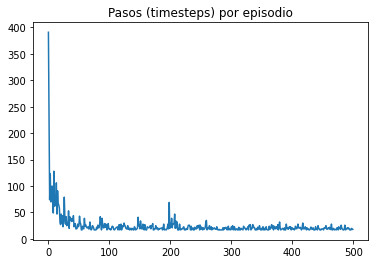

De este gráfico vemos que luego de los primeros 100 episodios, la cantidad de pasos por episodio se estabiliza por un valor por debajo de 50.

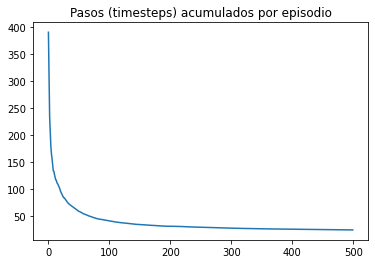

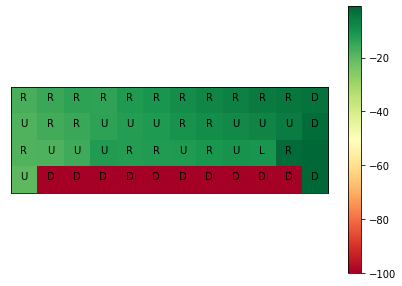

De la matriz de valores de acción-valor podemos ver que los estados de los bordes que no son el acantilado tienen valores más altos. El acantilado tiene los peores valores dados porque tiene una recompensa de -100 cuando el agente transiciona a dicho estado.

#### 2. Implementación de Q-Learning

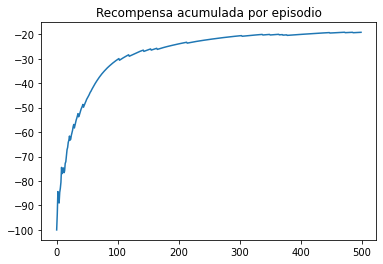

Podemos ver que converge a un valor mayor de recompensa acumulada en la misma cantidad de episodios que SARSA.

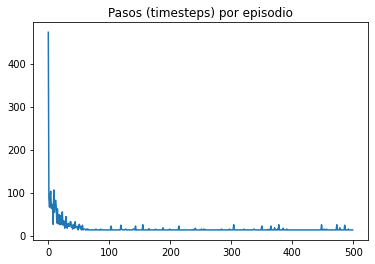

En cuanto a los pasos por episodio, parece que en los primeros 100 episodios se comporta parecido que SARSA, pero luego es más estable que SARSA.

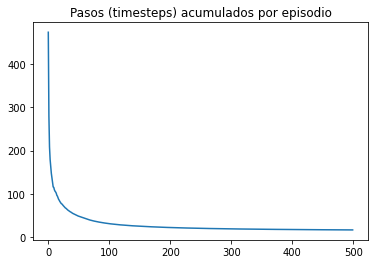

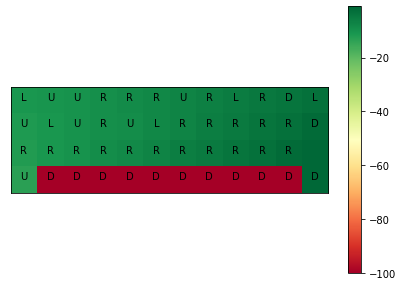

De este gráfico, podemos ver que los valores de la matriz valor-acción tienden a ser mayores a medida que se acerca a la columna de la meta, pero no necesariamente son menores en el borde del acantilado, a diferencia de SARSA.

¿Cómo converge con respecto a SARSA? ¿A qué se debe?

Para este problema particular, Q-learning parece aproximarse más rápido a la solución óptima (menor cantidad de pasos por episodio). Al visualizar la matriz de acciones, se puede observar que SARSA tiende a alejarse del cliff, por lo que tarda más en llegar a la meta (es más conservador), mientras que Q-Learning continúa por el borde del cliff hasta la meta.

#### 3. Ejecución con distintos hiperparámetros

Consideramos los siguientes valores de los hiperparámetros para evaluar:
* α = [0.5, 0.7, 1]  *learning rate*
* ϵ = [0.1, 0.3, 0.5] *probabilidad de elegir una acción aleatoriamente (probabilidad de explorar)*
* γ = [0.7, 1] *factor de descuento*

El learning rate nos va indicando cuánto vamos a avanzar en el aprendizaje. Este parámetro se elije entre el balance de que la convergencia sea rápida y que el aprendizaje no sea inestable.

ϵ nos indica cuál es la probabilidad de 'explorar', en la práctica habla más de la probabilidad de elegir una acción aleatoria estando en un cierto estado.

El factor de descuento es una decisión de diseño, e indica cuánta importancia se le da a las recompensas que se puede recibir a corto plazo frente a largo plazo. Si es más alto (cercano a 1), le damos más importancia a las de largo plazo. 

Probamos en total 18 combinaciones de hiperparámetros entre sí. 
Para evaluar como afectaban dichos hiperparámetros, grafiamos para SARSA y para Q-Learning, la recompensa acumulada y la cantidad de pasos para cada episodio.
Cada fila de graficos se corresponde a los mismos hiperparámetros. En cada fila tenemos en azul los resultados de SARSA y en naranja los de Q-learning. Los valores de los hiperparámetros para cada fila aparecen como el label de los gráficos de *Recompensa acumulada por episodio*, donde la a denota α, la g denota a γ y la e a ϵ. 


* Veremos primero las 6 combinaciones para las cuales α=0.5
 * En el caso en que α=0.5, γ=0.7 y ϵ=0.1, Q Learning tiene una convergencia estable luego de los primeros episodios y tiene los valores más altos de recompensa acumulada, la cantidad de pasos que hace por episodio no es estable, aunque sin embargo se mantiene menor a 80 pasos por episodio, lo cual queda dentro de lo obtenido con parámetros por defecto en el punto 2. Esta combinación de hiperparámetros con SARSA es inestable en cuanto a la cantidad de pasos, además a partir de un cierto episodio, el algoritmo desaprende y converge a un valor menor al máximo de recompensa que había obtenido.
  * α=0.5, γ=1 y ϵ=0.1: en este caso, SARSA tiene una covergencia más estable que Q-learning, aunque Q-learning obtiene recompensas mayores en menos pasos. En esta caso, el valor de ϵ nos indica que no se explora practicamente el espacio de acciones. γ nos indica que le da más importancia que antes a las recompensa posteriores. En este caso SARSA es estable en cuanto a la recompensa acumulada y sobretodo en cuanto a la cantidad de pasos, pero Q-learning obtiene muy buenos valores también (notése además que en SARSA el eje vertical del gráfico toma valores entre -100 y -20 y en Q-learning van de -24 a -20). Q-learning converge a valores altos de recompensa en menos pasos que SARSA.
  * α=0.5, γ=0.7 y ϵ=0.3: pareciera en este caso que explorando más las acciones posibles, da peor SARSA, ya que a partir de un cierto episodio desaprende y arranca a converger a un valor de recompensa acumulada peor que antes. También al observar como se comportó antes con γ=0.7, parece que empeora respecto a cuando γ=1. En este caso, que Q-learning pudo explorar más las acciones, cayó al acantilado. Pero rapidamente convergió a un valor de recompensa en los primeros 150 epsiodios. Además, convergió la cantidad de pasos a menos de 100 pasos por episodios dentro de los primeros 150 episodios. De los 3 casos que vimos hasta ahora, es el peor valor de recompensa acumulada que ha obtenido Q-learning .
  * α=0.5, γ=1 y ϵ=0.3: en este caos tenemos que Q-learning desaprendió al explorar más las acciones posibles y darle más importancia al valor de recompensa de estados futuros (γ =1). Podemos ver también que nunca supero los 100 pasos por episodio. En el caso de SARSA vemos que converge a un cierto valor de recompensa, que es peor que el de Q-learning para este caso, y se observa que en los momentos en que le costo más converger (en los primeros episodios), la cantidad de pasos que hizo por episodio fue alta, para luego más o menos estabilizarse. 
  * α=0.5, γ=0.7 y ϵ=0.5: En esta caso podemos ver que con ambos algoritmos se cayó al acantilado y ambos algoritmos al caer al acantilado tienen en los primeros episodiso una cantidad alta de pasos por episodio. A diferencia de Q-learning, SARSA no estabiliza la cantidad de pasos que hace por episodio, esto se ve principalmente en la segunda mitad, dado que comienza a desaprender y no logra volver a aprender. Ambos casos toman valores bastantes bajos de recompensa acumulada respecto con las otras combinaciones de hiperparámetros. En este caso, tenemos que la causa probable de esto es ϵ, ya que elegir una acción aleatoria tiene una probabilidad del 50%. De esto podemos pensar que es comveniniente que ϵ no tome un valor tan alto como 0.5, ya que entorpece el aprendizaje.
  * α=0.5, γ=1 y ϵ=0.5: En esta caso también tenemos una alta probabilidad de elegir una acción aleatoria, pero como γ=1 los algoritmos tienen más en cuenta que con γ=0.7 la recompensa a largo plazo, lo que parece que les permite converger y no tener tanta inestabilidad, sobretodo en el caso de SARSA. Además la cantidad de pasos para ambos algoritmos disminuyó significativamente respecto al caso anterior. Se puede ver que parece que Q-learning comienza a desaprender un poco en la segunda mitad de los episodios, convergiendo a un valor final similar al de SARSA. 

  Parece que para ambos, para SARSA y Q-learning, la combinación α=0.5, γ= 1 y ϵ =0.1 dió los mejores resultados.

* 6 combinaciones para las cuales α=0.75
 * α=0.75, γ=0.7 y ϵ=0.1: En este caso vemos que SARSA converge a un valor menor que la máxima recompensa que obtuvó, y el número de pasos que hace por episodio no se estabiliza. En cambio Q-learning converge establemente a un valor de recompenza entre -30 y -20 y sus pasos también son estables.
  * α=0.75, γ=1 y ϵ=0.1: En este caso, SARSA converge establemente a un valor ~ -40, mientras que Q-learning inicialmente es un poco inestable, termina convergiendo a un valor mejor de recompensa acumulada de ~ -23. La cantidad de pasos que realiza Q-learning es mucho menor que la de SARSA, pero ambos son relativamente estables. 
  * α=0.75, γ=0.7 y ϵ=0.3:  En cuanto a Q-learning podemos ver un comportamiento similar al anterior, convergiendo a un valor de recompensa acumulada un poco menor que antes. SARSA en cambio parece que desaprender porque empieza a tener una tendencia descendiente en la recompensa a medida que pasan los episodios, además de que los pasos no convergen con el aumento de los episodios. Podriamos decir a partir de todas las situaciones anteriores, que el número de pasos no convergente, llegando incluso al máximo de pasos permitidos es un indicio de que el agente está desaprendiendo.
  * α=0.75, γ=1 y ϵ=0.3: Aumenta γ=1 y SARSA se comporta mejor por más que ϵ >0.1. Podemos ver que ambos algoritmos convergen establemente, con Q-learning teniendo más estabilidad y una convergencia en menos pasos y a un valor de recompensa acumulada mayor. 
  * α=0.75, γ=0.7 y ϵ=0.5: En este caso ambos no convergen, SARSA teniendo mayor inestabilidad en la cantidad de pasos por episodios. Q-learning parecía funcionar bien por más que ϵ tomara valores distintos de 0.1, sin embargo a partir de este valor, ϵ=0.5, la probabilidad tan alta de elegir una acción random le afecta en el aprendizaje. SARSA es bastante susceptible a valores de ϵ distintos a 0.1, sin embargo si γ=1, al darle más peso a la recompenza a largo plazo, lograba converger de cualquier manera. 
  * α=0.75, γ=1 y ϵ=0.5: En este caso, tenemos que SARSA converge, en cambio Q-learning no. EL valor de γ=1 en SARSA hace que pueda converger, en cambio, en Q-learning pesa más que ϵ=0.5. 


De esto podemos concluir que SARSA es bastante sensible al valor de ϵ, donde su convergencia se asegura para valores de ϵ>0.1 si empleamos γ=1, caso contrario diverge. En cambio Q-learning converge con más valores de ϵ, divergiendo para ϵ=0.5, y en este caso el valor de γ no arregla la divergencia. 

En ambos agentes la mejor combinación de hiperparámetros es cuando ϵ=0.1, γ=1 al ser α=0.75.


* 6 combinaciones para las cuales α=1:

  * α=1, γ=0.7, ϵ=0.1: Tenemos que ambos convergen, con SARSA empezando a desaprender un poco hacia los últimos episodios. Q-learng converge establemente desde los primeros 50 episodios.
  * α=1,γ=1, ϵ= 0.1: En este caso para SARSA pasa algo similar al caso anterior, converge pero en los últimos episodios parece que desaprende algo. En este caso la cantidad de pasos por episodios para ambos algoritmos disminuyó. Q-learning converge a un valor de recompensa acumulada de ~ -23. Esta combinación de parámetros pareciera decirles a los agentes que le den más importancia al estado actual.
  * α=1,γ=0.7, ϵ= 0.3: En este caso ambos algoritmos no convergen. Y en el caso de SARSA la cantidad de pasos por episodio es muy alta. Parece que con una taza de aprendizaje de 1, Q-learning se vuelve más sensible al valor de ϵ.
  * α=1,γ=1, ϵ= 0.3: Ocurre algo similar al caso anterior, solamente que la recompenza máxima que alcanzan es menor. 
  * α=1,γ=0.7, ϵ= 0.5: Ninguno de los dos converge, y SARSA llega por episodio más veces a la cantidad máxima de pasos. 
  * α=1,γ=1, ϵ= 0.5: Q-learning converge a un cierto valor de recompensa ~ -90, muy malo respecto a los otros valores de recompensa que obtuvo antes. Además, para lograr ese valor de recompensa tiene una media de cantidad de pasos mucho más alta que en otras configuraciones de hiperparámetros. SARSA no converge y aumenta la cantidad de episodios en la cual llega al máximo de pasos permitidos. 

De esto podemos decir que como en general los agentes inicialmente se equivocan, un α=1 hace que aprendan dichas equivocaciones, dificultando o incluso impidiendo que converjan, si ϵ es distinto de 0.1. Con α=1 se vuelven muy sensibles de comenzar bien y no caer en el acantilado. El mejor resultado que se obtuvo fue para Q-learning con γ=1 (importancia en recompensas a largo plazo) y ϵ =0.1 (poca probabilidad de elegir una acción aleatoria).

En general, es mejor que ϵ no sea 0.5. El valor de α que tomemos nos va a indicar que tanto aprenden a partir del estado en el que está, por lo que se vuelve susceptible de los primeros episodios y se dificulta la convergencia o la obtención de un buen valor de convergencia si el agente en los primeros episodios cayó al acantilado. Q-learning es menos susceptible a la diferencia entre ϵ = 0.1 ó 0.3, SARSA sí es susceptible a estos valores. En dicho caso se puede regular la convergencia con SARSA aumentando el valor de γ. En general se obtuvieron mejores resultados con α=0.5 y con Q-learning que con SARSA. El mejor resultado de SARSA se obtuvo para la combinación α=0.5, γ=1 y ϵ=0.1. Para Q-learning α=0.5, γ=1 y ϵ=0.1. Q-learning convergió más veces que SARSA, por lo que es más flexible. Además siempre ejecutó menos cantidad de pasos, por lo que es más rápido.

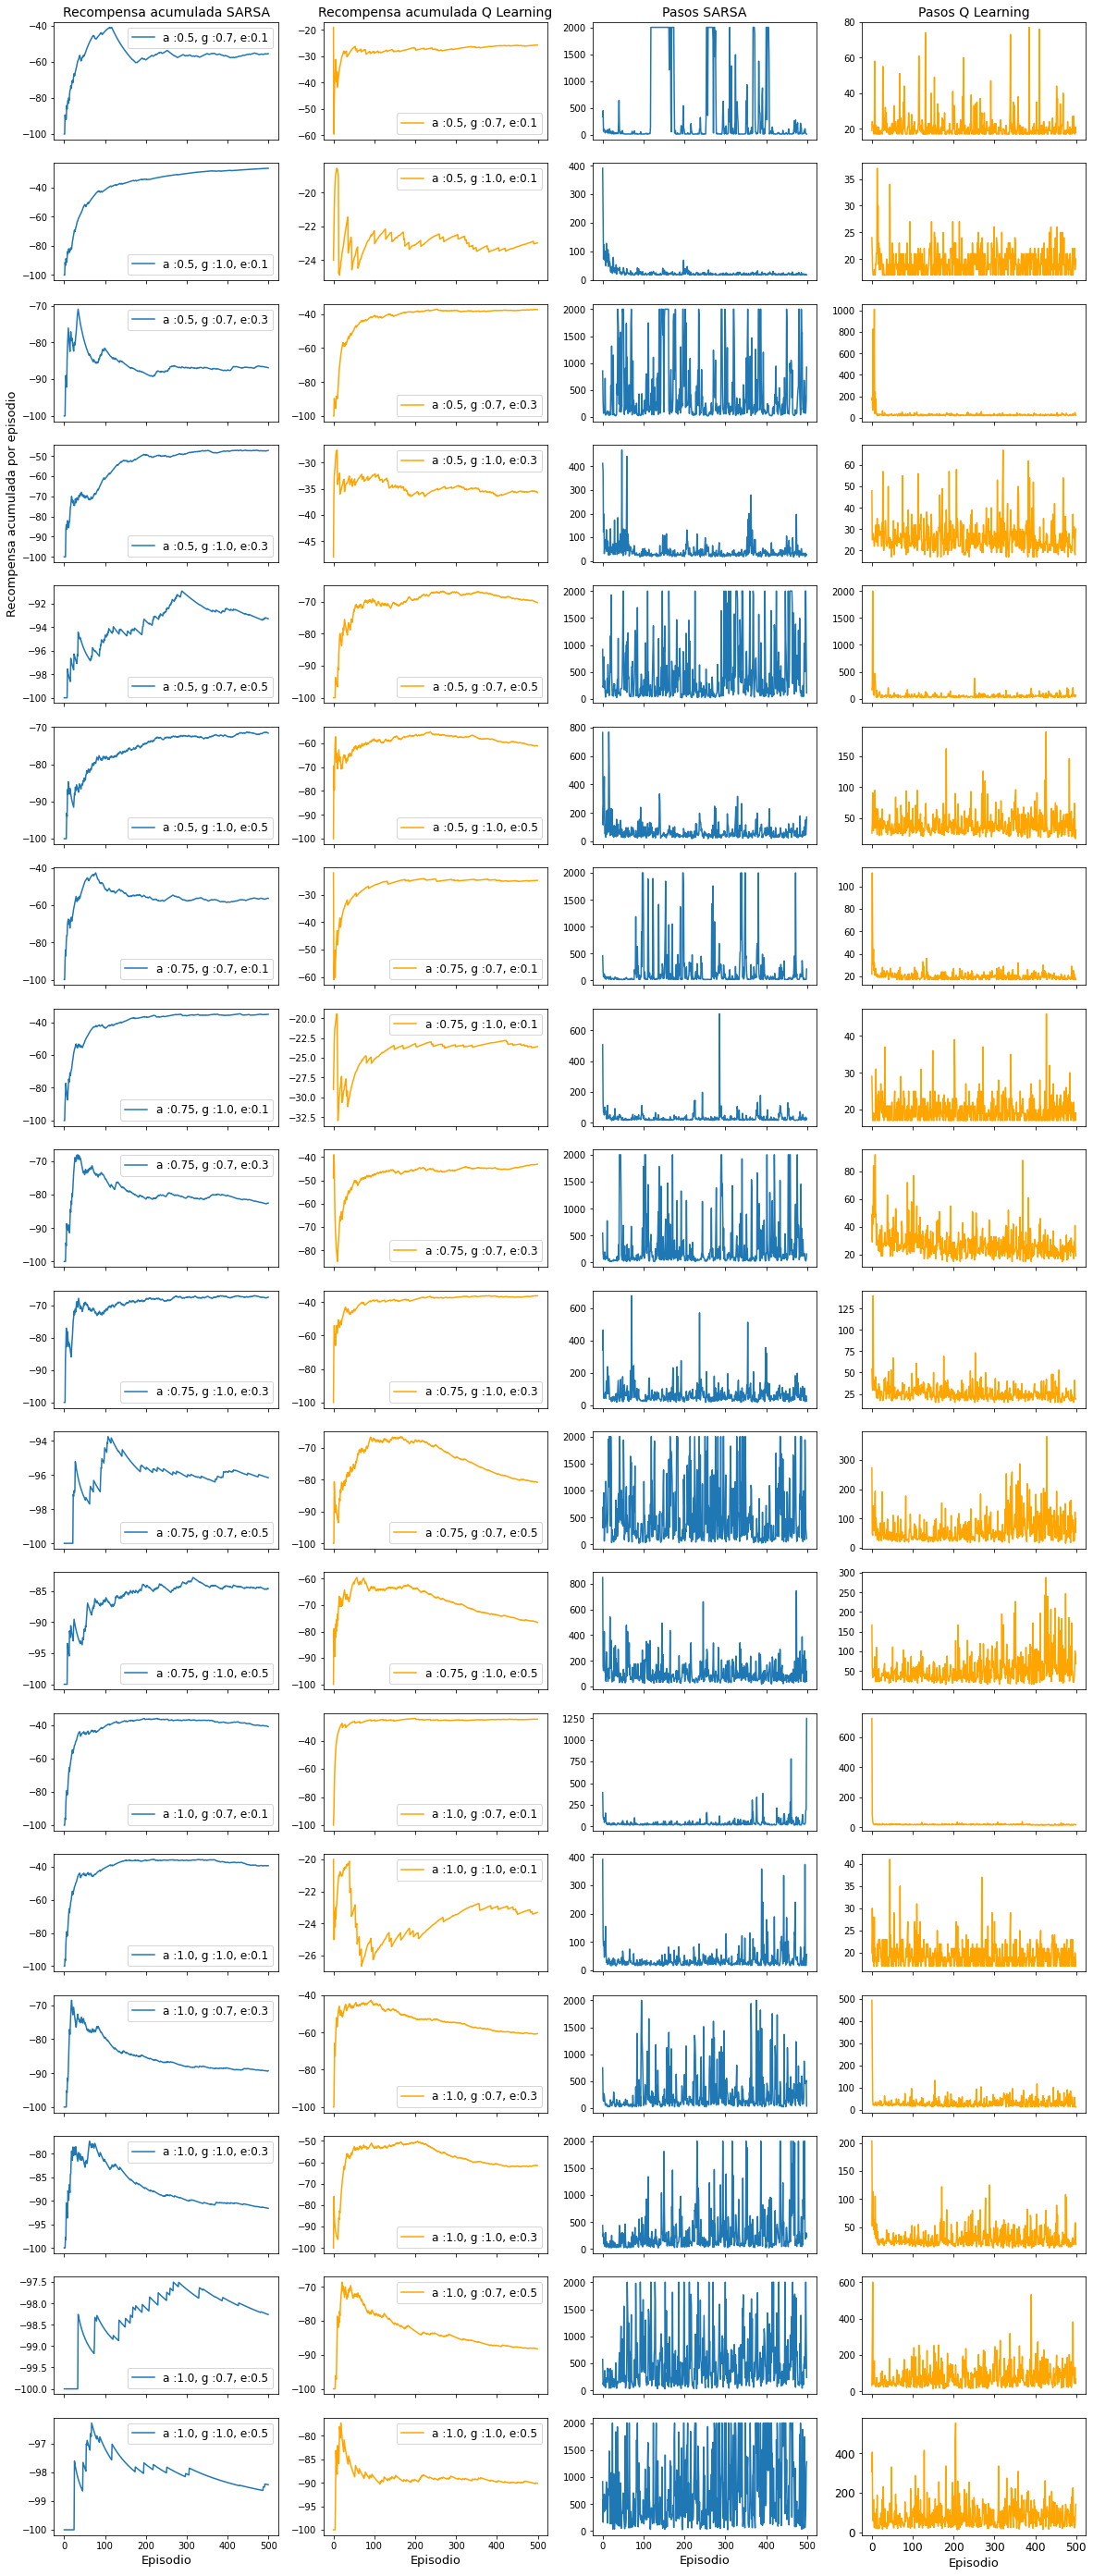

#### 4. Q-Learning con Softmax policy


Empleamos Softmax para Q-learning y los siguientes fueron los resultados:

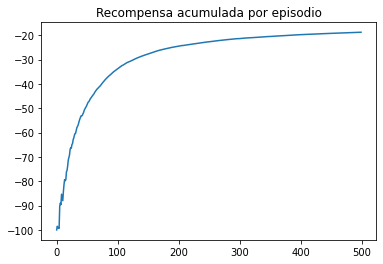

Si comparamos este gráfico  con el obtenido en el punto 2, podemos ver que se suavizó la curva de recompensa acumulada por episodio.

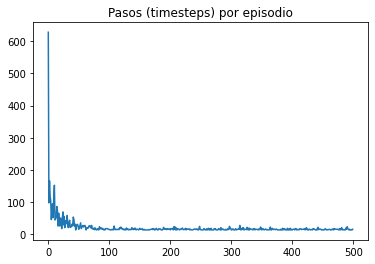

Pasa lo mismo con la curva de pasos por episodio.

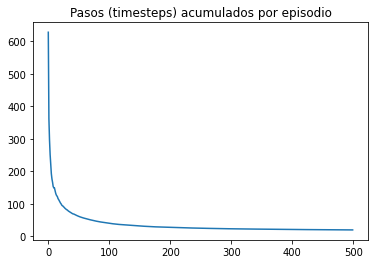

Matriz de acción-valor para Q-learning con Softmax.

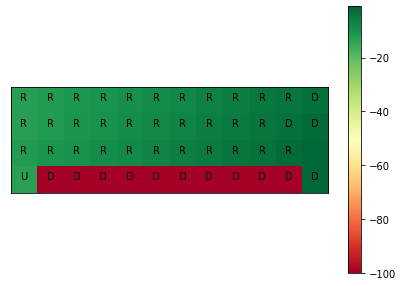

Matriz de acción-valor para Q-learning sin Softmax.

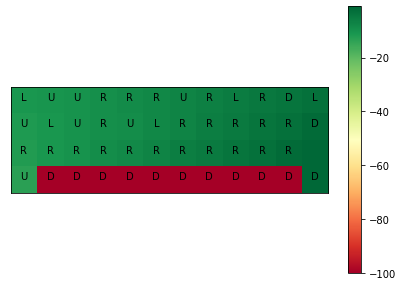

La diferencia entre ambas matrices de acción valor es la letra que se termina asignando a cada casilla, con softmax se obtiene en la mayoría de las casillas la opción 'R' de right, cuando al emplear Q-learning sin softmax se obtenian también otros valores, aunque en su mayoría 'R.'

## Ejecución de los códigos:

### 1. Implementación y ejecución de algoritmo SARSA

In [ ]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    q_sa_t = q.get((state, action), 0.0)  #extraigo el valor de q para esa accion y estado de los valores de q que 
                                          #se obtuvieron a partir de epsilon-greedy
    q_sa_t1 = q.get((next_state, next_action), 0.0)  #lo mismo para el proximo estado

    q[(state,action)] = q_sa_t + alpha * (reward + gamma * q_sa_t1 - q_sa_t)
    
    #pass

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
#tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

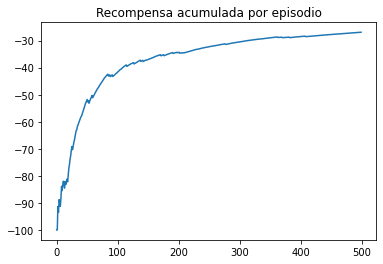

In [ ]:
plot_reward_per_episode(reward_ep)

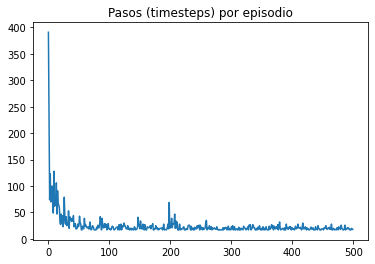

In [ ]:
plot_steps_per_episode(timesteps_ep)

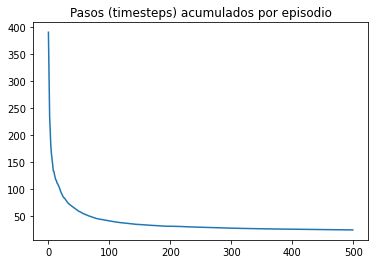

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)

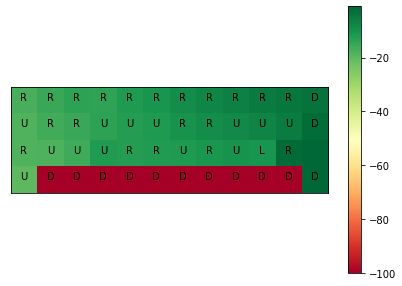


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)

### 2. Implementación y ejecución de algoritmo Q-Learning

La diferencia con SARSA es cuándo tenemos que llamar a la función choose_action en la función run, además de que denemos obtener el valor de Q para la acción que lo maximiza para el estado dado en cada step de un episodio. Con SARSA la llamamos una vez para cada episodio e inicializamos la acción para todos los steps, en cambio para Q-Learning, llamamos a choose_action en cada step, ahí es que hacemos la selección de la acción A que se va a emplear en ese step. 

In [ ]:
def run_QL():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0


        
        while not done:
            #Cambio el lugar donde elije la acción
            # elige una acción basado en el estado actual
            action = choose_action(state)

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
                  

            episode_reward += reward
            learn_QL(state, action, reward, next_state)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                #action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [ ]:
def learn_QL(state, action, reward, next_state):
    """
    Performs a Q Learning update for a given state transition

    """
    #Obtengo la accion para la cual Q es máxima para el proximo estado
    q_values = [q.get((next_state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    #Lo comentado no es necesario y me tiró un error, era para extraer la llave del valor q max, pero no es necesario
    #maxq_key = list(q.keys())[list(q.values()).index(max_q)] #obtengo la llave para el valor maximo de q, ahora me quiero quedar con la a
    #maxq_action = maxq_key[0] #aquí guardo cual es la acción para la cual Q es max
    # Q(s',a) para  a que maximisa q, lo tengo guardado en max_Q
    #al final esto no era necesario, solo necesitaba max_q para el proximo estado,
    #la llave hubiera sido necesaria si hubiera llamado al valor Qmax(s',a) de la siguiente forma:
    #q_sa_max = q.get((next_state, maxq_key[0]), 0.0)

    q_sa_t = q.get((state, action), 0.0)  #extraigo el valor de q para esa accion y estado de los valores de q que 
                                          #se obtuvieron a partir de epsilon-greedy
   

    q[(state,action)] = q_sa_t + alpha * (reward + gamma* max_q - q_sa_t)
    
    #pass

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.01

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [ ]:
avg_steps_per_episode_QL, timesteps_ep_QL, reward_ep_QL = run_QL()

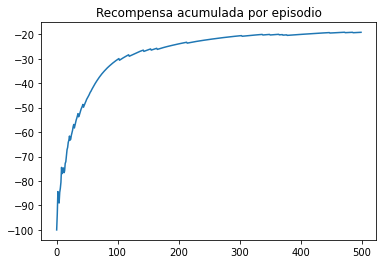

In [ ]:
plot_reward_per_episode(reward_ep_QL)

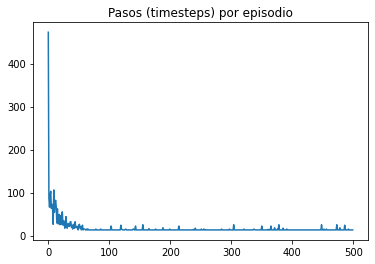

In [ ]:
plot_steps_per_episode(timesteps_ep_QL)

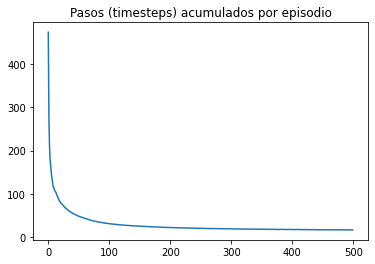

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep_QL)

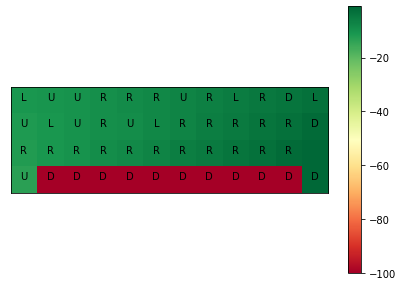


 Matriz de mejor acción-valor (en números): 

 [[ -10.96875     -10.5         -10.           -9.42590092   -8.60173431
    -7.82678786   -6.95181274   -6.17884195   -5.32077026   -4.62776823
    -3.82002472   -2.9765625 ]
 [ -11.66620369  -10.90738399  -10.28054602   -9.5023558    -8.74253664
    -7.82573144   -6.89819419   -5.93554284   -4.9597135    -3.98126531
    -2.99242208   -1.99996342]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)

¿Cómo converge con respecto a SARSA? ¿A qué se debe?

Para este problema particular, Q-learning parece aproximarse más rápido a la solución óptima (menor cantidad de pasos por episodio). Al visualizar la matriz de acciones, se puede observar que SARSA tiende a alejarse del cliff, por lo que tarda más en llegar a la meta (es más conservador), mientras que Q-Learning continúa por el borde del cliff hasta la meta.

### 3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame( columns=['alpha', 'epsilon', 'gamma','time_steps_ep', 'reward_ep', 'time_steps_ep_QL', 'reward_ep_QL'])

In [ ]:
alpha_hp = np.arange(0.5,1.1,0.25)
print(alpha_hp)
epsilon_hp = np.arange(0.1,0.6,0.2)
print(epsilon_hp)
gamma_hp = np.array((0.7,1))
gamma_hp

[0.5  0.75 1.  ]
[0.1 0.3 0.5]


array([0.7, 1. ])

Valores tomados de los hiperparámetros
* α = [0.5, 0.7, 1]
* ϵ = [0.1, 0.3, 0.5]
* γ = [0.7, 1]

In [ ]:
len(alpha_hp)

3

In [ ]:
# alpha_hp = np.array([0.1, 0.5, 2])
# epsilon_hp = np.array([0.01, 0.1, 1])
# gamma_hp = np.array([0.1, 1, 3])

In [ ]:
def functions_for_plot(reward_ep):
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    return(reward_per_episode)

In [ ]:
#label='a :'+str(alpha)+', g :'+str(round(gamma,1))+', e:'+
label
str(round(epsilon,1))

'0.1'

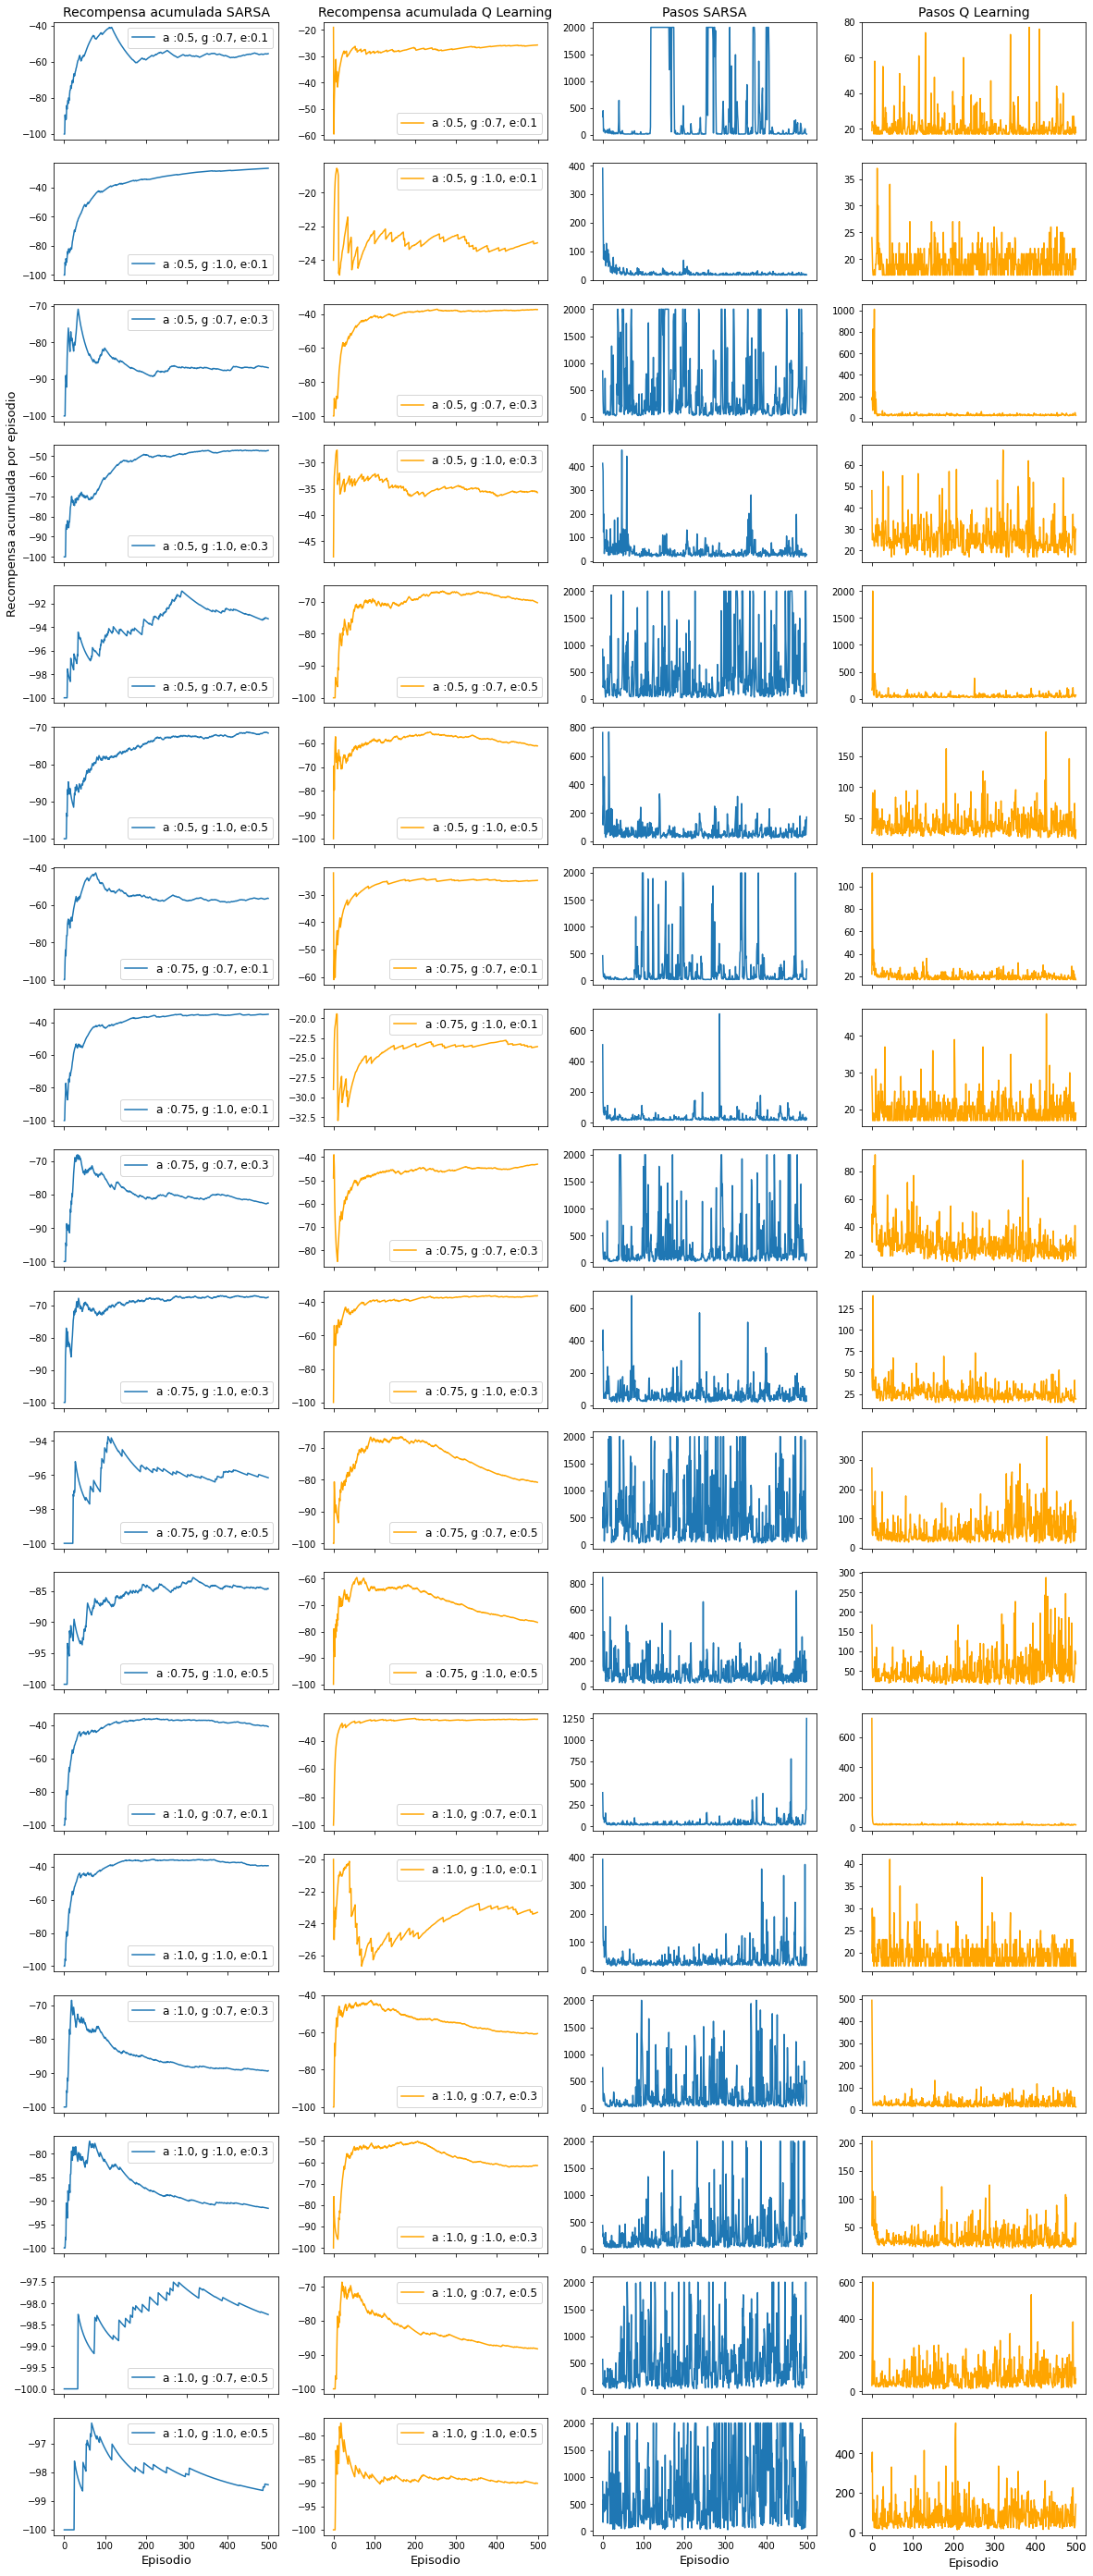

In [ ]:
fig, axs = plt.subplots(18,4, figsize=(20, 50), sharex=True)

plt.tick_params(axis='both', which='major', labelsize=12)

axs[0,0].set_title('Recompensa acumulada SARSA', fontsize= 14)
axs[0,1].set_title('Recompensa acumulada Q Learning', fontsize= 14)

axs[0,2].set_title('Pasos SARSA', fontsize= 14)
axs[0,3].set_title('Pasos Q Learning', fontsize= 14)

axs[3,0].set_ylabel('Recompensa acumulada por episodio', fontsize=13)

#axs[3,2].set_ylabel('Pasos (timesteps) por episodio', fontsize=12)

axs[17,0].set_xlabel('Episodio', fontsize=13)
axs[17,1].set_xlabel('Episodio', fontsize=13)
axs[17,2].set_xlabel('Episodio', fontsize=13)
axs[17,3].set_xlabel('Episodio', fontsize=13)

m= 0

for i in range(3):
  for j in range(3):
    for k in range(2):
      q = {}

  # definimos sus híper-parámetros básicos

      alpha = alpha_hp[i]
      
      epsilon = epsilon_hp[j]
      gamma = gamma_hp[k]

      episodes_to_run = 500

      env = gym.make("CliffWalking-v0")
      actions = range(env.action_space.n)

      # se declara una semilla aleatoria
      random_state = np.random.RandomState(42)

      avg_steps_per_episode, timesteps_ep, reward_ep = run()
      avg_steps_per_episode_QL, timesteps_ep_QL, reward_ep_QL = run_QL()

      steps_plot = np.array(timesteps_ep)
      steps_plot_QL = np.array(timesteps_ep_QL)

      axs[m, 0].plot(functions_for_plot(reward_ep), label='a :'+str(alpha)+', g :'+str(round(gamma,1))+', e:'+str(round(epsilon,1)))
      axs[m, 1].plot(functions_for_plot(reward_ep_QL), color='orange', label='a :'+str(alpha)+', g :'+str(round(gamma,1))+', e:'+str(round(epsilon,1)))
      axs[m, 0].legend(fontsize = 12)
      axs[m, 1].legend(fontsize = 12)

      axs[m, 2].plot(np.array(range(0, len(steps_plot))), steps_plot)
      axs[m, 3].plot(np.array(range(0, len(steps_plot_QL))), steps_plot_QL, color='orange')

      m += 1

      #df1 = pd.DataFrame(data =[alpha, gamma, epsilon, timesteps_ep, reward_ep, timesteps_ep_QL, reward_ep_QL], columns =['alpha', 'epsilon', 'gamma','time_steps_ep', 'reward_ep', 'time_steps_ep_QL', 'reward_ep_QL'])
      #plot_reward_per_episode(reward_ep_QL)
      #plot_reward_per_episode(reward_ep)

### 4. Q-Learning con softmax policy

In [ ]:
def softmax(state):
    """
    tau es un hiperparámetro denominado temperatura  y se utiliza para controlar la proporcionalidad en las probabilidades resultantes: un parámetro de temperatura muy elevado resultará en 
    las probabilidades distribuidas igualitariamente entre todas las acciones mientras que un valor muy bajo asignará el grueso de la probabilidad al elemento con mayor recompensa. 
    Es básicamente el parámetro que regula en qué medida se prioriza la exploración vs la explotación. 
    """
    w = [np.exp(q.get((state, action), 0.0) / tau) for action in actions]
    return w/sum(w)  #Acá ya tenemos todo el diccionario normalizado en la suma, así que simplemente hay que llamar la acción en cuestión

In [ ]:
def choose_action_softmax(state):
    """
    Chooses an action according to the learning previously performed 
    using a softmax policy
    """

    action_proba = softmax(state)
    # Elección aleatoria de acción con probabilidades action_proba
    action = np.random.choice(a=np.arange(0, len(action_proba)), p=action_proba)
    return actions[action]

In [ ]:
def run_QL_softmax():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        while not done:
            #Cambio el lugar donde elije la acción
            # elige una acción basado en probabilidades
            action = choose_action_softmax(state)

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
                  

            episode_reward += reward
            learn_QL(state, action, reward, next_state)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                #action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 0.5

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [ ]:
avg_steps_per_episode_QL, timesteps_ep_QL, reward_ep_QL = run_QL_softmax()

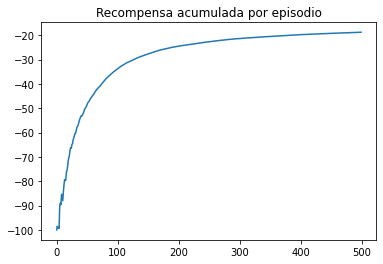

In [ ]:
plot_reward_per_episode(reward_ep_QL)

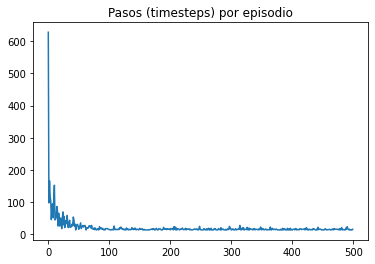

In [ ]:
plot_steps_per_episode(timesteps_ep_QL)

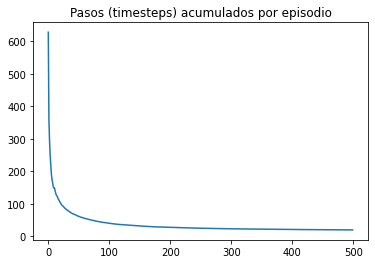

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep_QL)

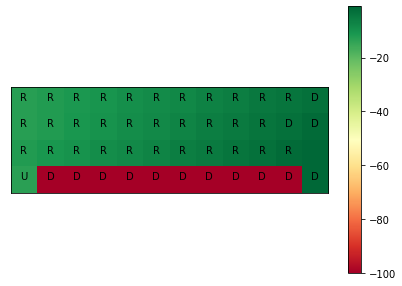


 Matriz de mejor acción-valor (en números): 

 [[ -12.84740134  -12.08926884  -11.23582625  -10.31892076   -9.45303392
    -8.60989949   -7.65775362   -6.77109554   -5.82665738   -4.8634573
    -3.93486828   -2.99747257]
 [ -12.91739122  -11.96048373  -10.97912942   -9.99041075   -8.99159263
    -7.99584278   -6.99844064   -5.99985633   -4.99992725   -3.99999514
    -2.99999966   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)